# Code to take data using the scope and plot relevant histograms. Will output energy resolution and associated errors.

In [1]:
import os
import sys

import importlib
import h5py # This is the python library that creates files/stores data sets
import numpy as np
import matplotlib.pyplot as plt

#local scripts 
import enResFit

Define output file and data set names

In [2]:
#path='/Users/asteinhe/AstroPixData/102021_amp1/'
path='/Users/asteinhe/AstroPixData/102021_amp1/'
outName='cadmium109_45min'
dsName='run1'

Boolean run options

In [3]:
savePlots=False

In [4]:
f = h5py.File(path+outName+'.h5py', 'a')

### List the data sets within a file (check to make sure your run is there):

In [5]:
list(f.keys())

['run1', 'run1_integral', 'run1_peaks', 'run1_t']

### Data analysis/plotting: assign the data set as the array "plot_array."

In [6]:
plot_array = f[dsName] # insert desired data set name here
time_axis = np.array(f[dsName+"_t"])

### Plot 10% of all traces to look at the data and perform a common sense check. Also look for a stretch of data that can be used to determine noise.

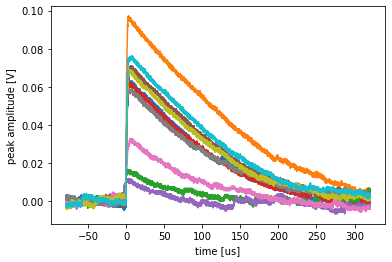

In [7]:
for i in range(int(len(plot_array)*0.1)):
    plt.plot(time_axis*1e6, plot_array[i])
    
plt.xlabel('time [us]')
plt.ylabel('peak amplitude [V]')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_traces.png')

### Plot a histogram of the peaks using matplotlib to get a sense of what the data looks like and where the peak is.

In [8]:
peaks=f[dsName+'_peaks']
traces=len(peaks)

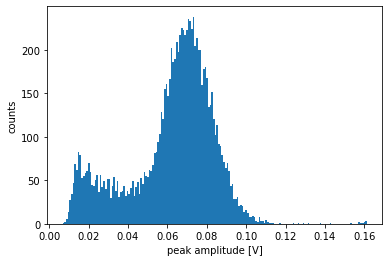

In [9]:
#ultra fine binning for debugging input
plt.hist(peaks, bins=180)
plt.xlabel('peak amplitude [V]')
plt.ylabel('counts')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_peakHist.png')


### Plot a more rigorous histogram and fit the data to find the energy resolution.

### The scipy.optimize function will fit the histogram of your peaks to a Gaussian. The x data is the bins_2 array and the y data is the output from the np.histogram function. In order for the fit to work, you have to make reasonable guesses for the amplitude, the mean, and the sigma of the histogram.
### Change the title of the plot, save figure if it looks good

In [10]:
f.close()
g = h5py.File(path+outName+'_scaling.h5py', 'a')
scalingDict=np.array(g[dsName+"_scaling"])
#get scale of scope - voltage resolution
scale=scalingDict[3] #3rd value = YMULT

g.close()
f = h5py.File(path+outName+'.h5py', 'a')
peaks=f[dsName+'_peaks']


0.0008
0.16126240000000003
201
200
Amplitude = 206.7974, Mu = 0.0697, Sigma = 0.0128
The energy resolution is approximately 43.29 percent.


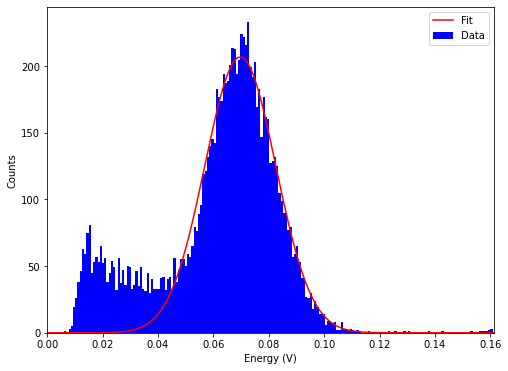

In [11]:
popt, en_res, pcov=enResFit.GaussFit(peaks,scale,savePlots)

### Calculate the errors associated with the energy resolution:

In [12]:
(Amp, Mu, Sigma) = popt
(Amp_err, Mu_err, Sigma_err) = np.sqrt(np.diag(pcov))
# Error propagation
partial_sigma = (2.355*100)/Mu
partial_mu = (2.355*100*Sigma)/(Mu**2)
stdev_er = np.sqrt(((partial_sigma**2)*(Sigma_err**2))+((partial_mu**2)*(Mu_err)**2))
print("Error in amplitude is %0.3f. \nError in mu is %0.6f. \nError in sigma is %0.6f." %(Amp_err, Mu_err, Sigma_err))
print("The error in the energy resolution is %0.5f percent."%(stdev_er))

Error in amplitude is 4.906. 
Error in mu is 0.000351. 
Error in sigma is 0.000351.
The error in the energy resolution is 1.20578 percent.


Save energy resolution values in txt file

In [13]:
k=open(path+outName+"_"+dsName+"_enRes.txt", "a")
k.write(dsName+'\n')
k.write("PEAKS\n")
k.write("Amplitude = %d \nMu = %0.4f \nSigma = %0.4f" %(Amp, Mu, Sigma)+"\n")
k.write("Energy resolution = %0.2f" %(abs(en_res))+"%\n")
k.write("Error in amplitude = %0.3f \nError in mu = %0.6f \nError in sigma = %0.6f" %(Amp_err, Mu_err, Sigma_err)+"\n")
k.write("Error in energy resolution = %0.5f"%(stdev_er)+"%\n")
k.close()

# Do the same for the trace integral

In [14]:
integ=f[dsName+'_integral']

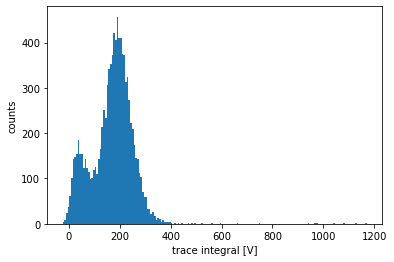

In [15]:
#ultra fine binning for debugging input
plt.hist(integ, bins=180)
plt.xlabel('trace integral [V]')
plt.ylabel('counts')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_integHist.png')

8.0
1170.8887999999997
146
145
Amplitude = 463.0629, Mu = 182.9415, Sigma = 62.9408
The energy resolution is approximately 81.02 percent.


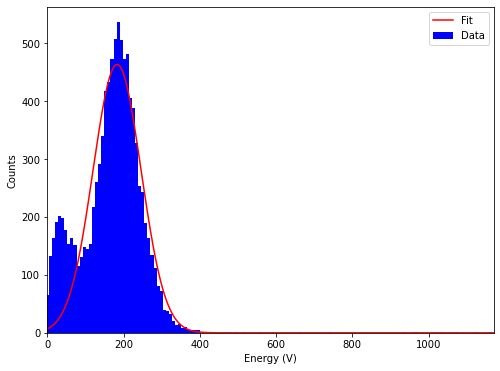

In [16]:
popt_integ, en_res_integ, pcov_integ = enResFit.GaussFit(integ,scale*10000,savePlots) #10,000 points in each trace

In [17]:
(Amp, Mu, Sigma) = popt
(Amp_err, Mu_err, Sigma_err) = np.sqrt(np.diag(pcov))
# Error propagation
partial_sigma = (2.355*100)/Mu
partial_mu = (2.355*100*Sigma)/(Mu**2)
stdev_er = np.sqrt(((partial_sigma**2)*(Sigma_err**2))+((partial_mu**2)*(Mu_err)**2))
print("Error in amplitude is %0.3f. \nError in mu is %0.6f. \nError in sigma is %0.6f." %(Amp_err, Mu_err, Sigma_err))
print("The error in the energy resolution is %0.5f percent."%(stdev_er))

Error in amplitude is 4.906. 
Error in mu is 0.000351. 
Error in sigma is 0.000351.
The error in the energy resolution is 1.20578 percent.


In [18]:
k=open(path+outName+"_"+dsName+"_enRes.txt", "a")
k.write("INTEGRAL\n")
k.write("Amplitude = %d \nMu = %0.4f \nSigma = %0.4f" %(Amp, Mu, Sigma)+"\n")
k.write("Energy resolution = %0.2f" %(abs(en_res))+"%\n")
k.write("Error in amplitude = %0.3f \nError in mu = %0.6f \nError in sigma = %0.6f" %(Amp_err, Mu_err, Sigma_err)+"\n")
k.write("Error in energy resolution = %0.5f"%(stdev_er)+"%\n")
k.close()

### Saving the h5py files as text files

save peaks as list separated by new lines (in scientific notation)

In [19]:
np.savetxt(path+outName+'_'+dsName+"_peaks.txt", peaks)
np.savetxt(path+outName+'_'+dsName+"_integral.txt", integ)

### If you are done working with a file, ***make sure you close it!*** h5py does not like it when files are left open and you change files and/or kill the kernel.

In [20]:
f.close()

YOU DID IT!!!